# Тут просто дебажим код

# Импорт данных

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from catboost import Pool, CatBoostClassifier
import numpy as np
import re
from string import punctuation
from sklearn.metrics import roc_curve, auc

# Загрузка данных

In [6]:
engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )

In [7]:
def load_and_merge_data(engine):
    # Чтение данных таблицы user_data
    query = "SELECT * FROM user_data"
    user_data = pd.read_sql(query, engine)

    # Чтение данных таблицы post_text_df
    query = "SELECT * FROM post_text_df"
    post_text_df = pd.read_sql(query, engine)

    # Чтение ограниченного количества данных таблицы feed_data
    query = "SELECT * FROM feed_data LIMIT 100000"
    feed_data = pd.read_sql(query, engine)

    # Переименование столбцов идентификаторов
    user_data = user_data.rename(columns={'id': 'user_id'})
    post_text_df = post_text_df.rename(columns={'id': 'post_id'})

    # Объединение таблиц
    data = feed_data.merge(user_data, on='user_id', how='left')
    data = data.merge(post_text_df, on='post_id', how='left')

    return data

data = load_and_merge_data(engine)

In [8]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-13 20:05:23,48444,1905,view,1,0,20,Russia,Vologda,0,Android,ads,Premier League planning Cole date\n\nThe Premi...,sport
1,2021-11-13 20:06:01,48444,1905,like,0,0,20,Russia,Vologda,0,Android,ads,Premier League planning Cole date\n\nThe Premi...,sport
2,2021-11-13 20:06:03,48444,6497,view,0,0,20,Russia,Vologda,0,Android,ads,Jack Black is an annoying character.This is an...,movie
3,2021-11-13 20:08:09,48444,4404,view,0,0,20,Russia,Vologda,0,Android,ads,This is probably the most uninvolving film Ive...,movie
4,2021-11-13 20:09:58,48444,1520,view,0,0,20,Russia,Vologda,0,Android,ads,Dallaglio his own man to the end\n\nControvers...,sport


In [5]:
data.head()

,timestamp,user_id,post_id,action,target,gender,exp_group,os,text
0,2021-10-02 19:45:03,89033,5219,view,0,0,0,Android,When a saboteur blows up a controversial gover...
1,2021-10-02 19:45:37,89033,5514,view,0,0,0,Android,Arthur Askeys great skill as a comic was in th...
2,2021-10-02 19:47:57,89033,6618,view,0,0,0,Android,I think the opening 20 minutes of this film is...
3,2021-10-02 19:48:16,89033,5479,view,0,0,0,Android,Follow-up to 1973s far better Cleopatra Jones ...
4,2021-10-02 19:52:01,89033,952,view,0,0,0,Android,UK troops on Ivory Coast standby\n\nDowning St...


# Обработка временных меток

In [3]:
# Преобразование формата временных меток в объект datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Извлечение признаков из временных меток
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Расчет времени с момента последнего действия для каждого пользователя
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)

# Удаление столбца временных меток
data = data.drop('timestamp', axis=1)

# Кодирование категориальных признаков

In [4]:
# One-hot encoding для 'country', 'city' и 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding для 'gender', 'os' и 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])

# Создание дополнительных признаков

In [5]:
def word_count(X):
    return np.array([len(re.findall(r'\b\w+\b', text)) for text in X])
def sentence_count(X):
    return np.array([len(re.findall(r'[.!?]+', text)) for text in X])
def avg_word_length(X):
    return np.array([sum(len(word) for word in re.findall(r'\b\w+\b', text)) / len(re.findall(r'\b\w+\b', text)) if len(re.findall(r'\b\w+\b', text)) > 0 else 0 for text in X])
def punctuation_count(X):
    return np.array([sum(1 for char in text if char in punctuation) for text in X])

# Применение функций извлечения признаков к столбцу 'text'
word_counts = word_count(data['text'])
sentence_counts = sentence_count(data['text'])
avg_word_lengths = avg_word_length(data['text'])
punctuation_counts = punctuation_count(data['text'])

# Добавление новых признаков в виде столбцов в DataFrame
data['word_count'] = word_counts
data['sentence_count'] = sentence_counts
data['avg_word_length'] = avg_word_lengths
data['punctuation_count'] = punctuation_counts


# Обработка TF-IDF

In [6]:
# Инициализация TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000) # Вы можете настроить max_features в зависимости от ваших потребностей

# Обучение vectorizer на столбце 'text' и преобразование текстовых данных
tfidf_matrix = vectorizer.fit_transform(data['text'])

# Преобразование матрицы TF-IDF в DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Конкатенация исходных данных с DataFrame TF-IDF
data_with_tfidf = pd.concat([data.drop(columns=['text']), tfidf_df], axis=1)

In [66]:
data_with_tfidf

,user_id,post_id,action,target,gender,age,exp_group,os,source,day_of_week,...,wrong,year,years,yes,yet,york,you,young,your,youre
763,9630,5639,1,0,1,26,0,0,0,3,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
764,9630,3849,1,1,1,26,0,0,0,3,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
765,9630,3849,0,0,1,26,0,0,0,3,...,0.00000,0.085624,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
766,9630,840,1,0,1,26,0,0,0,3,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
767,9630,6456,1,0,1,26,0,0,0,3,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.096408,0.0,0.146733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99337,164854,1728,1,0,0,34,3,1,1,0,...,0.02675,0.016705,0.0,0.0,0.0,0.0,0.014356,0.0,0.000000,0.0
99338,164854,1504,1,0,0,34,3,1,1,0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
99339,164854,1457,1,0,0,34,3,1,1,0,...,0.00000,0.077382,0.0,0.0,0.0,0.0,0.132995,0.0,0.000000,0.0
99340,164854,1849,1,0,0,34,3,1,1,0,...,0.00000,0.033229,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


# Отбор признаков на основе взаимной информации

In [7]:
X = data_with_tfidf.drop(['target', 'action'], axis=1)
y = data_with_tfidf['target']

# Вычисление взаимной информации между каждым признаком и целевой переменной
mi_scores = mutual_info_classif(X, y, random_state=42)

# Создание DataFrame с именами признаков и соответствующими им оценками MI
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Сортировка DataFrame по оценкам MI в порядке убывания
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# При необходимости выберите k лучших признаков с помощью SelectKBest
selector = SelectKBest(mutual_info_classif, k=50)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)

Top k features based on mutual information:
Index(['user_id', 'gender', 'age', 'exp_group', 'os', 'source', 'hour_of_day',
       'time_since_last_action', 'country_Russia', 'city_Blagoveshchensk',
       'city_Cheboksary', 'city_Mariupol', 'city_Nakhodka', 'city_Rezh',
       'topic_covid', 'topic_movie', '100', 'air', 'become', 'campaign',
       'change', 'computer', 'costs', 'currently', 'day', 'de', 'death',
       'england', 'fun', 'howard', 'ill', 'itself', 'johnson', 'lost', 'music',
       'paul', 'pretty', 'process', 'really', 'remember', 'role', 'saying',
       'short', 'showed', 'shown', 'stage', 'such', 'tax', 'until', 'won'],
      dtype='object')


In [20]:
preselected_features_1 = ['user_id', 'gender', 'exp_group', 'os', 'day_of_week', 'hour_of_day',
       'time_since_last_action', 'country_Russia', 'city_Kansk', 'city_Kazan',
       'city_Mangghystaū', 'city_Michurinsk', 'city_Moscow', 'city_Pavlovo',
       'city_Samara', 'topic_covid', 'topic_entertainment', 'topic_movie',
       'user_views', 'user_likes', 'post_views',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views',
       'sentence_count', 'punctuation_count', 'australian', 'based', 'city',
       'ending', 'failed', 'given', 'idea', 'life', 'likely', 'opportunity',
       'order', 'paid', 'party', 'past', 'political', 'robert', 'scene',
       'seem', 'wanted']

preselected_features_2 = ['user_id', 'gender', 'age', 'exp_group', 'os', 'source', 'hour_of_day',
       'time_since_last_action', 'country_Russia', 'city_Blagoveshchensk',
       'city_Cheboksary', 'city_Mariupol', 'city_Nakhodka', 'city_Rezh',
       'topic_covid', 'topic_movie', '100', 'air', 'become', 'campaign',
       'change', 'computer', 'costs', 'currently', 'day', 'de', 'death',
       'england', 'fun', 'howard', 'ill', 'itself', 'johnson', 'lost', 'music',
       'paul', 'pretty', 'process', 'really', 'remember', 'role', 'saying',
       'short', 'showed', 'shown', 'stage', 'such', 'tax', 'until', 'won']

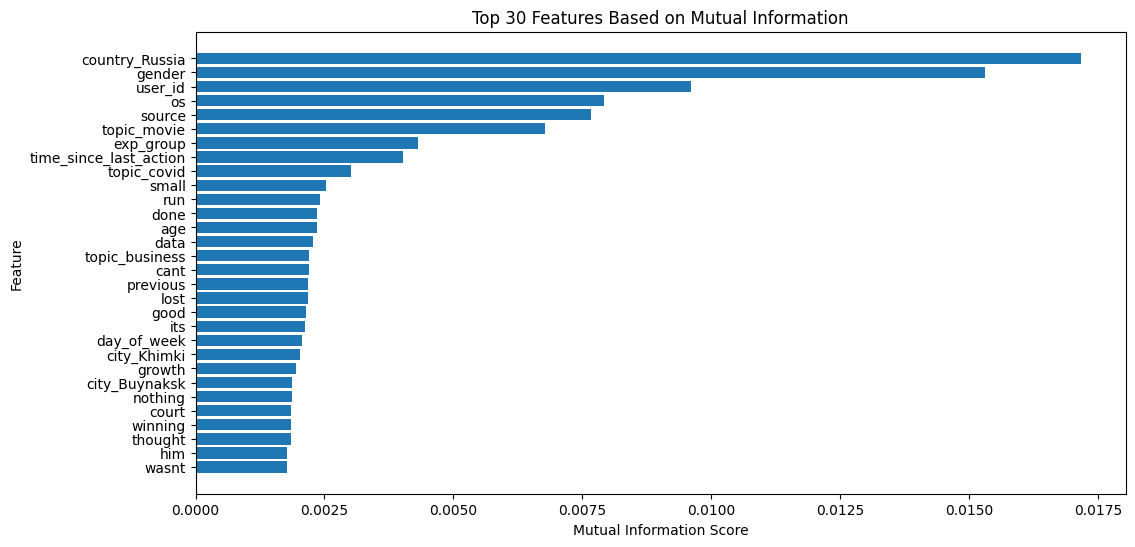

In [10]:
# Установка количества признаков для отображения
top_k = 30

# Получение топ-k признаков
top_k_features = mi_scores_df.head(top_k)

# Визуализация топ-k признаков
plt.figure(figsize=(12, 6))
plt.barh(top_k_features['feature'], top_k_features['mi_score'], align='center')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top {} Features Based on Mutual Information'.format(top_k))
plt.gca().invert_yaxis()
plt.show() 

# Обучение модели CatBoost

## Train-test split

Этот код формирует выборку данных с заданными признаками, выбирая топ-k признаков с использованием взаимной информации, без утечки данных, временной метки, 'action' и 'text'. Затем данные разбиваются на обучающую и тестовую выборки с заданным отношением размеров, и рандомным состоянием генератора псевдослучайных чисел.

In [67]:
# Выборка данных с выбранными функциями, топ-k функций с взаимной информацией, без утечки данных, временной метки, 'action' и 'text'
X = data_with_tfidf[selected_features]

# Выборка целевой переменной
y = data_with_tfidf['target']

# Убедиться, что каждый столбец уникален
X = X.loc[:,~X.columns.duplicated()]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Мы работаем с данными, где каждый объект имеет некоторый идентификатор пользователя (user_id). Модель должна быть обучена на этих данных, учитывая группы объектов с одинаковыми идентификаторами пользователей. Прежде всего, мы создаем столбец group_id, который представляет собой уникальный идентификатор группы для каждого пользователя.

Затем мы сортируем обучающие и тестовые наборы данных по group_id, что позволяет нам группировать объекты с одинаковыми идентификаторами пользователей вместе. Это делается для обучения и тестирования модели в соответствии с группами пользователей.

Мы создаем объекты Pool для обучающей и тестовой выборок с информацией о группах пользователей. Объект Pool является специальной структурой данных, используемой библиотекой CatBoost для эффективной работы с данными. В этом случае мы передаем group_id для каждого объекта, чтобы CatBoost мог использовать эту информацию во время обучения и тестирования модели.

Далее мы обучаем классификатор CatBoost с использованием метрики PrecisionAt:top=5. Эта метрика оценивает качество предсказания топ-5 классов. Модель обучается на train_pool и валидируется на test_pool. Важно отметить, что в этой задаче мы используем группированные данные, поэтому CatBoost будет учитывать идентификаторы групп при обучении и оценке.

Данные, которые поступают в модель, представляют собой обучающие и тестовые наборы данных с удаленным столбцом user_id. Вместо этого, информация о группах пользователей передается через объекты Pool.

После обучения модели мы получаем модель, которая оптимизирована для метрики PrecisionAt:top=5. Это означает, что модель будет хорошо работать в задаче предсказания 5 наиболее вероятных классов для каждого объекта, учитывая идентификаторы групп пользователей.

## Обучение модели на Precision@5 

Мы создаем группы данных на основе идентификатора пользователя 'user_id', чтобы иметь возможность проводить обучение с учетом группировки данных. Затем мы сортируем данные по группам и создаем объекты Pool для обучения и тестирования с колонкой 'group_id', которые затем будут использоваться для обучения модели и оценки ее производительности.

In [48]:
# Создание ID группы на основе столбца 'user_id'
unique_user_ids = X_train['user_id'].unique()
group_id_dict = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
X_train['group_id'] = X_train['user_id'].map(group_id_dict)
X_test['group_id'] = X_test['user_id'].map(group_id_dict)

# Сортировка наборов данных для обучения и тестирования по 'group_id'
X_train = X_train.sort_values(by='group_id')
y_train = y_train.loc[X_train.index]

X_test = X_test.sort_values(by='group_id')
y_test = y_test.loc[X_test.index]

# Создание объектов Pool для обучающей и тестовой выборок с колонкой 'group_id'
train_pool = Pool(X_train.drop(columns=['user_id']), y_train, group_id=X_train['group_id'])
test_pool = Pool(X_test.drop(columns=['user_id']), y_test, group_id=X_test['group_id'])


In [49]:
# Обучение модели CatBoost с использованием метрики PrecisionAt:top=5
from catboost import CatBoostClassifier

precision_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='PrecisionAt:top=5',
                           eval_metric='PrecisionAt:top=5',
                           random_seed=42,
                           verbose=100)

precision_model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.0426087	test: 0.0373913	best: 0.0373913 (0)	total: 8.94ms	remaining: 8.94s
100:	learn: 0.3226087	test: 0.1565217	best: 0.1660870 (53)	total: 863ms	remaining: 7.68s
200:	learn: 0.4504348	test: 0.1547826	best: 0.1660870 (53)	total: 1.71s	remaining: 6.79s
300:	learn: 0.5478261	test: 0.1486957	best: 0.1660870 (53)	total: 2.55s	remaining: 5.92s
400:	learn: 0.6173913	test: 0.1460870	best: 0.1660870 (53)	total: 3.38s	remaining: 5.05s
500:	learn: 0.6808696	test: 0.1530435	best: 0.1660870 (53)	total: 4.21s	remaining: 4.2s
600:	learn: 0.7156522	test: 0.1539130	best: 0.1660870 (53)	total: 5.07s	remaining: 3.37s
700:	learn: 0.7504348	test: 0.1469565	best: 0.1660870 (53)	total: 5.92s	remaining: 2.52s
800:	learn: 0.7713043	test: 0.1495652	best: 0.1660870 (53)	total: 6.78s	remaining: 1.69s
900:	learn: 0.7939130	test: 0.1426087	best: 0.1660870 (53)	total: 7.62s	remaining: 837ms
999:	learn: 0.8200000	test: 0.1426087	best: 0.1660870 (53)	total: 8.44s	remaining: 0us

bestTest = 0.1660869565
b

# Сохранение и загрузка модели CatBoost

In [50]:
precision_model.save_model('catboost_precision_model.cbm')

In [51]:
# Загрузка сохраненной модели CatBoost из файла и выполнение прогноза на тестовой выборке
from_file = CatBoostClassifier()
from_file.load_model('catboost_model.cbm')
from_file.predict(test_pool)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Обучение модели на Recall@5 

In [52]:
recall_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='RecallAt:top=5',
                           eval_metric='RecallAt:top=5',
                           random_seed=42,
                           verbose=100)

recall_model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.0107600	test: 0.0517370	best: 0.0517370 (0)	total: 9.24ms	remaining: 9.23s
100:	learn: 0.0517603	test: 0.1516333	best: 0.1562369 (52)	total: 855ms	remaining: 7.61s
200:	learn: 0.0803337	test: 0.1568987	best: 0.1583480 (197)	total: 1.69s	remaining: 6.7s
300:	learn: 0.0971811	test: 0.1520628	best: 0.1643947 (240)	total: 2.55s	remaining: 5.92s
400:	learn: 0.1115718	test: 0.1505411	best: 0.1643947 (240)	total: 3.38s	remaining: 5.04s
500:	learn: 0.1232233	test: 0.1525970	best: 0.1643947 (240)	total: 4.2s	remaining: 4.19s
600:	learn: 0.1305419	test: 0.1553621	best: 0.1643947 (240)	total: 5.01s	remaining: 3.33s
700:	learn: 0.1404418	test: 0.1490682	best: 0.1643947 (240)	total: 5.83s	remaining: 2.49s
800:	learn: 0.1452069	test: 0.1500800	best: 0.1643947 (240)	total: 6.64s	remaining: 1.65s
900:	learn: 0.1536196	test: 0.1424972	best: 0.1643947 (240)	total: 7.45s	remaining: 818ms
999:	learn: 0.1607649	test: 0.1420198	best: 0.1643947 (240)	total: 8.29s	remaining: 0us

bestTest = 0.1643

## Обучение модели на MAP@5 

In [56]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='PFound:top=5',
                           eval_metric='PFound:top=5',
                           random_seed=42,
                           verbose=100)

model.fit(train_pool, eval_set=test_pool)


0:	test: 0.1300974	best: 0.1300974 (0)	total: 8.26ms	remaining: 8.25s
100:	test: 0.4350205	best: 0.4506558 (61)	total: 744ms	remaining: 6.62s
200:	test: 0.4253565	best: 0.4510609 (150)	total: 1.45s	remaining: 5.75s
300:	test: 0.4427490	best: 0.4568099 (286)	total: 2.16s	remaining: 5.02s
400:	test: 0.4142271	best: 0.4568099 (286)	total: 2.87s	remaining: 4.28s
500:	test: 0.4016544	best: 0.4568099 (286)	total: 3.56s	remaining: 3.55s
600:	test: 0.4026233	best: 0.4568099 (286)	total: 4.27s	remaining: 2.84s
700:	test: 0.4051973	best: 0.4568099 (286)	total: 4.99s	remaining: 2.13s
800:	test: 0.4158141	best: 0.4568099 (286)	total: 5.72s	remaining: 1.42s
900:	test: 0.4071468	best: 0.4568099 (286)	total: 6.42s	remaining: 706ms
999:	test: 0.4045434	best: 0.4568099 (286)	total: 7.13s	remaining: 0us

bestTest = 0.4568098913
bestIteration = 286

Shrink model to first 287 iterations.


- bestTest = 0.4451217663 for MAP@5
- bestTest = 0.1603712149 for Recall@5
- bestTest = 0.1660869565 for Precision@5

# Сравнение моделей с помощью ROC AUC

In [57]:
# Расчет метрики AUC для каждой модели на тестовой выборке
from sklearn.metrics import roc_auc_score

# Делаем прогнозы на тестовой выборке с помощью всех трех моделей
map5_preds = model.predict_proba(test_pool)[:, 1]
recall5_preds = recall_model.predict_proba(test_pool)[:, 1]
precision5_preds = precision_model.predict_proba(test_pool)[:, 1]

# Рассчитываем метрику AUC для каждой модели
map5_auc = roc_auc_score(test_pool.get_label(), map5_preds)
recall5_auc = roc_auc_score(test_pool.get_label(), recall5_preds)
precision5_auc = roc_auc_score(test_pool.get_label(), precision5_preds)

# Выводим метрику AUC для каждой модели
print("MAP@5 AUC:", map5_auc)
print("Recall@5 AUC:", recall5_auc)
print("Precision@5 AUC:", precision5_auc)


MAP@5 AUC: 0.6245267087884262
Recall@5 AUC: 0.6277951215643344
Precision@5 AUC: 0.6189000538927956


Сохраняем выбранную модель

In [55]:
model.save_model('catboost_MAP_model.cbm')